# Tabnet : Self-supervised learning


## Example : Fraud Detection

### Import packages

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip3 install xgboost
!pip3 install pytorch_tabnet
!pip3 install iterative-stratification

In [ ]:
import torch
print(torch.__version__)
import torchvision
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
# from sklearn.model_selection import StratifiedKFold

from pytorch_tabnet.tab_model import  TabNetClassifier
import xgboost
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 

import os
import random
import sys
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

from tqdm import tqdm
from sklearn.metrics import log_loss

# from iterstrat.ml_stratifiers import MultilabelStratifiedKFold, MultilabelStratifiedShuffleSplit
# from sklearn.metrics import roc_auc_score

from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# from sklearn.manifold import TSNE
# from sklearn.compose import ColumnTransformer
# from mpl_toolkits.mplot3d import Axes3D

1.10.0+cu111


In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVISE = torch.device('cpu')

In [ ]:
data_path = '/content/drive/MyDrive/Project/research/data/'
dataset = pd.read_csv(data_path+'creditcard.csv')
dataset

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [ ]:
dataset.columns = map(str.lower, dataset.columns)
dataset.rename(columns={'class': 'label'}, inplace=True)

dataset.shape

(284807, 31)

### Preprocessing 


*   amount 변수 로그화
*   time 변수 제거
*   변수 정규화



In [ ]:
# amount
dataset['amount'] = np.log(dataset.amount + 1)

# time
dataset["time"] = dataset["time"].apply(lambda x : x / 3600 % 24)

# drop time variable
dataset = dataset.drop('time', axis=1)

# scaler
scaler = MinMaxScaler()
colnames_all = list(dataset)
dataset[colnames_all] = scaler.fit_transform(dataset[colnames_all])

dataset.head()

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,v18,v19,v20,v21,v22,v23,v24,v25,v26,v27,v28,amount,label
0,0.935192,0.766490,0.881365,0.313023,0.763439,0.267669,0.266815,0.786444,0.475312,0.510600,0.252484,0.680908,0.371591,0.635591,0.446084,0.434392,0.737173,0.655066,0.594863,0.582942,0.561184,0.522992,0.663793,0.391253,0.585122,0.394557,0.418976,0.312697,0.493873,0.0
1,0.978542,0.770067,0.840298,0.271796,0.766120,0.262192,0.264875,0.786298,0.453981,0.505267,0.381188,0.744342,0.486190,0.641219,0.383840,0.464105,0.727794,0.640681,0.551930,0.579530,0.557840,0.480237,0.666938,0.336440,0.587290,0.446013,0.416345,0.313423,0.128583,0.0
2,0.935217,0.753118,0.868141,0.268766,0.762329,0.281122,0.270177,0.788042,0.410603,0.513018,0.322422,0.706683,0.503854,0.640473,0.511697,0.357443,0.763381,0.644945,0.386683,0.585855,0.565477,0.546030,0.678939,0.289354,0.559515,0.402727,0.415489,0.311911,0.584923,0.0
3,0.941878,0.765304,0.868484,0.213661,0.765647,0.275559,0.266803,0.789434,0.414999,0.507585,0.271817,0.710910,0.487635,0.636372,0.289124,0.415653,0.711253,0.788492,0.467058,0.578050,0.559734,0.510277,0.662607,0.223826,0.614245,0.389197,0.417669,0.314371,0.475117,0.0
4,0.938617,0.776520,0.864251,0.269796,0.762975,0.263984,0.268968,0.782484,0.490950,0.524303,0.236355,0.724477,0.552509,0.608406,0.349419,0.434995,0.724243,0.650665,0.626060,0.584615,0.561327,0.547271,0.663392,0.401270,0.566343,0.507497,0.420561,0.317490,0.419792,0.0


### Train-test split 



*   6:2:2
*   array 형태로 바꿔주기





In [ ]:
# train test split
df_train_, df_test = train_test_split(dataset, test_size=0.2)
df_train, df_valid = train_test_split(df_train_, test_size=0.2)

x_train = df_train_.drop(['label'], axis = 1)
y_train = df_train_["label"].values

x_valid = df_valid.drop(['label'], axis = 1)
y_valid = df_valid["label"].values

x_test = df_test.drop(['label'], axis=1)
y_test = df_test['label'].values

print(x_train.shape, y_train.shape, x_valid.shape, y_valid.shape, x_test.shape, y_test.shape)

(227845, 29) (227845,) (45569, 29) (45569,) (56962, 29) (56962,)


In [ ]:
x_train= x_train.to_numpy()
x_valid= x_valid.to_numpy()
x_test= x_test.to_numpy()


### Pretrainer

*   mask type: entmax 사용
  - sparsemax의 일반화 모듈. sparse한 data에 사용하지만 sparsemax보다 부드러워 최적화에 더 알맞음





In [ ]:
import matplotlib as plt
from pytorch_tabnet.pretraining import TabNetPretrainer

#TabNet Pretrainer

max_epochs = 50

pretrainer = TabNetPretrainer(
    # cat_idxs=cat_idxs,
    # cat_dims=cat_dims,
    # cat_emb_dim=3,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type='entmax', # "sparsemax",
    n_steps=4,
    n_shared=2,
    n_independent=2,
    scheduler_params=dict(mode="min", #
                          patience=5,
                          min_lr=1e-5,
                          factor=0.9,),
    scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,      #                   
    verbose=10,
)

pretrainer.fit(
    X_train=x_train,
    eval_set=[x_valid],
    max_epochs=max_epochs, patience=20,
    batch_size=1024, virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
    pretraining_ratio=0.8,
) 

reconstructed_X, embedded_X = pretrainer.predict(x_valid)
assert(reconstructed_X.shape==embedded_X.shape)

Device used : cpu
epoch 0  | loss: 174.42772| val_0_unsup_loss: 1.10042 |  0:00:19s
epoch 10 | loss: 1.06931 | val_0_unsup_loss: 1.06389 |  0:03:35s
epoch 20 | loss: 1.10758 | val_0_unsup_loss: 1.21013 |  0:06:54s
epoch 30 | loss: 1.03031 | val_0_unsup_loss: 1.01021 |  0:10:14s
epoch 40 | loss: 1.05499 | val_0_unsup_loss: 1.0508  |  0:13:36s
Stop training because you reached max_epochs = 50 with best_epoch = 37 and best_val_0_unsup_loss = 1.00387
Best weights from best epoch are automatically used!


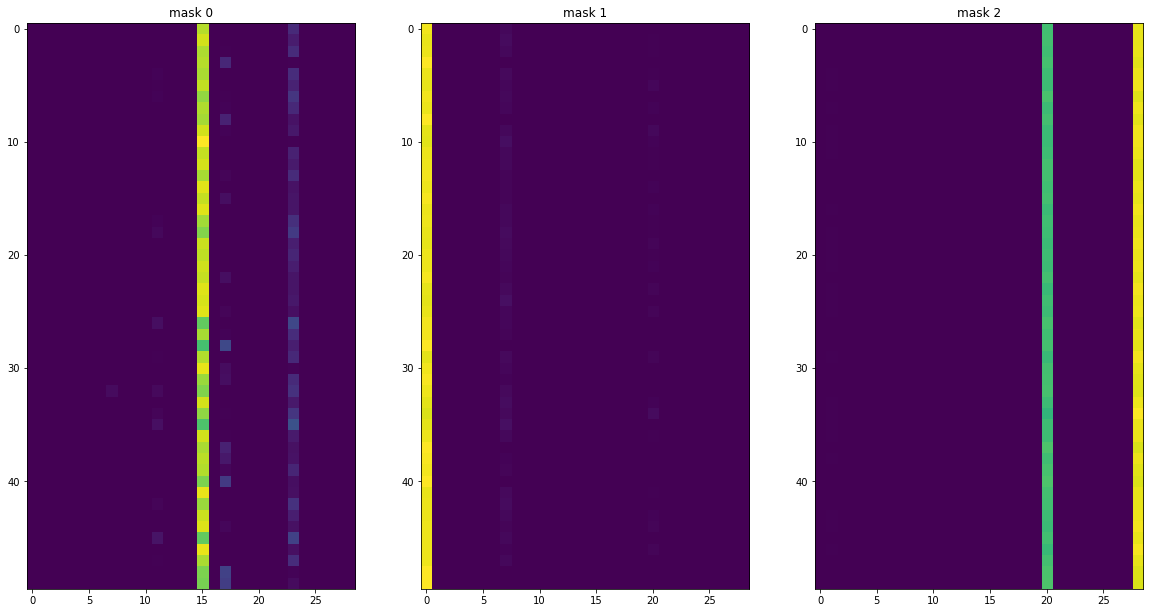

In [ ]:
import matplotlib.pyplot as plt

unsupervised_explain_matrix, unsupervised_masks = pretrainer.explain(x_valid)

fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(unsupervised_masks[i][:50])
    axs[i].set_title(f"mask {i}")

### Modeling

In [ ]:
clf = TabNetClassifier(optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=2e-2),
                       scheduler_params={"step_size":10, # how to use learning rate scheduler
                                         "gamma":0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='sparsemax' # This will be overwritten if using pretrain model
                      )

Device used : cpu


In [ ]:
clf.fit(
    X_train=x_train, y_train=y_train,
    eval_set=[(x_train, y_train), (x_valid, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=['logloss'],
    max_epochs=max_epochs , patience=20,
    batch_size=1024, virtual_batch_size=128,
    num_workers=0,
    weights=1,
    drop_last=False,
    from_unsupervised= pretrainer,
) 

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)
/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: n_steps changed from 3 to 4
  warnings.warn(wrn_msg)


Loading weights from unsupervised pretraining
epoch 0  | loss: 0.21547 | train_logloss: 0.21112 | valid_logloss: 0.21003 |  0:00:23s
epoch 1  | loss: 0.10578 | train_logloss: 0.13908 | valid_logloss: 0.13995 |  0:00:46s
epoch 2  | loss: 0.07764 | train_logloss: 0.06911 | valid_logloss: 0.06884 |  0:01:09s
epoch 3  | loss: 0.06212 | train_logloss: 0.05123 | valid_logloss: 0.05053 |  0:01:32s
epoch 4  | loss: 0.0535  | train_logloss: 0.04027 | valid_logloss: 0.03934 |  0:01:55s
epoch 5  | loss: 0.04016 | train_logloss: 0.03843 | valid_logloss: 0.03762 |  0:02:18s
epoch 6  | loss: 0.04797 | train_logloss: 0.04968 | valid_logloss: 0.0488  |  0:02:40s
epoch 7  | loss: 0.03363 | train_logloss: 0.02692 | valid_logloss: 0.02479 |  0:03:03s
epoch 8  | loss: 0.02718 | train_logloss: 0.03148 | valid_logloss: 0.0306  |  0:03:25s
epoch 9  | loss: 0.02743 | train_logloss: 0.0169  | valid_logloss: 0.01493 |  0:03:48s
epoch 10 | loss: 0.02091 | train_logloss: 0.01796 | valid_logloss: 0.01746 |  0:04:1

### Loss 

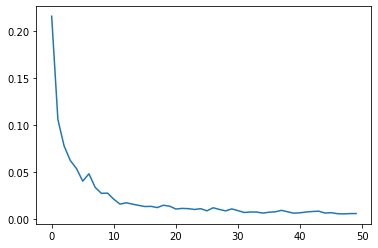

In [ ]:
plt.plot(clf.history['loss'])

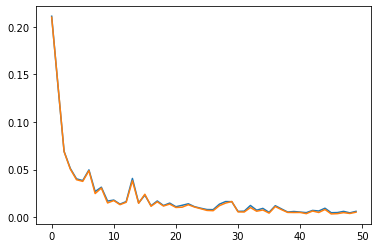

In [ ]:
plt.plot(clf.history['train_logloss'])
plt.plot(clf.history['valid_logloss'])

### Performances / Prediction

#### Validation set



In [ ]:
preds_valid = clf.predict_proba(x_valid) #valid set
preds_valid_ = preds_valid[:,1]
pred_valid =[ 0 if i < 0.5 else 1 for i in preds_valid_]

# valid_auc = roc_auc_score(y_score=preds_valid[:,1], y_true=y_valid) #valid set

In [ ]:
confusion_matrix(y_valid, pred_valid)

array([[45453,    37],
       [    0,    79]])

In [ ]:
r = recall_score(y_valid, pred_valid)
print(f"Recall for 'Fraud Detection' : {r}")
f1 = f1_score(y_valid, pred_valid)
print(f"F1 score for 'Fraud Detection' : {f1}")

Recall for 'Fraud Detection' : 1.0
F1 score for 'Fraud Detection' : 0.8102564102564103


#### Predition set

In [ ]:
preds = clf.predict_proba(x_test) #
test_pred_ = preds[:,1]
test_pred =[ 0 if i < 0.5 else 1 for i in test_pred_]

In [ ]:
confusion_matrix(y_test, test_pred)

array([[56766,    92],
       [   18,    86]])

In [ ]:
r = recall_score(y_test, test_pred)
print(f"Recall for 'Fraud Detection' : {r}")
f1 = f1_score(y_test, test_pred)
print(f"F1 score for 'Fraud Detection' : {f1}")

Recall for 'Fraud Detection' : 0.8269230769230769
F1 score for 'Fraud Detection' : 0.6099290780141844


In [ ]:
test_pred = preds[:,1]
predictions =[ 'N' if i < 0.5 else 'Y' for i in test_pred]
pd.value_counts(predictions)

N    56784
Y      178
dtype: int64

### Importance features : self-supervised learning

In [ ]:
colnames_train = colnames_all.remove('label')
importance_tabNet_self = pd.DataFrame(clf.feature_importances_,index=colnames_all).sort_values(0, ascending = False)
importance_tabNet_self.columns = ["importance_self"]
importance_tabNet_self.head()

,importance_self
v16,0.198098
v9,0.191061
v14,0.135929
v18,0.075353
v1,0.073322


In [ ]:
explain_matrix, masks = clf.explain(x_test)

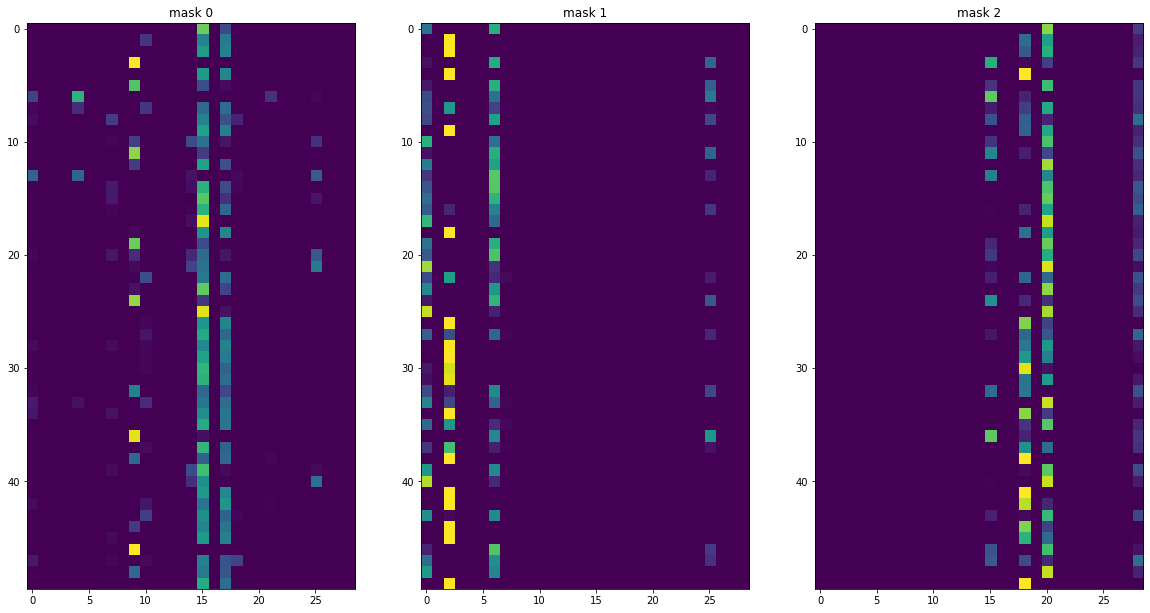

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")

## Supervised learning without pretraining

In [ ]:
clf2 = TabNetClassifier(optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=2e-2),
                       scheduler_params={"step_size":10, # how to use learning rate scheduler
                                         "gamma":0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='sparsemax' # This will be overwritten if using pretrain model
                      )

Device used : cpu


In [ ]:
### 참고용 : supervised learning without pretraining

clf2.fit(
    X_train=x_train, y_train=y_train,
    eval_set=[(x_train, y_train), (x_valid, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=['logloss'],
    max_epochs=max_epochs , patience=20,
    batch_size=1024, virtual_batch_size=128,
    num_workers=0,
    weights=1,
    drop_last=False,
    # from_unsupervised= pretrainer,
    # loss_fn=torch.nn.functional.CrossEntropyLoss
    ) 

epoch 0  | loss: 0.15672 | train_logloss: 0.51158 | valid_logloss: 0.51285 |  0:00:22s
epoch 1  | loss: 0.07019 | train_logloss: 0.09215 | valid_logloss: 0.09435 |  0:00:40s
epoch 2  | loss: 0.05109 | train_logloss: 0.04141 | valid_logloss: 0.04213 |  0:00:57s
epoch 3  | loss: 0.04604 | train_logloss: 0.04362 | valid_logloss: 0.04501 |  0:01:15s
epoch 4  | loss: 0.03886 | train_logloss: 0.02756 | valid_logloss: 0.02899 |  0:01:33s
epoch 5  | loss: 0.02929 | train_logloss: 0.03215 | valid_logloss: 0.03369 |  0:01:52s
epoch 6  | loss: 0.02504 | train_logloss: 0.02497 | valid_logloss: 0.02657 |  0:02:10s
epoch 7  | loss: 0.02518 | train_logloss: 0.0262  | valid_logloss: 0.02854 |  0:02:28s
epoch 8  | loss: 0.02153 | train_logloss: 0.03331 | valid_logloss: 0.03408 |  0:02:47s
epoch 9  | loss: 0.02015 | train_logloss: 0.03228 | valid_logloss: 0.03333 |  0:03:05s
epoch 10 | loss: 0.0246  | train_logloss: 0.01613 | valid_logloss: 0.0164  |  0:03:23s
epoch 11 | loss: 0.01829 | train_logloss: 0

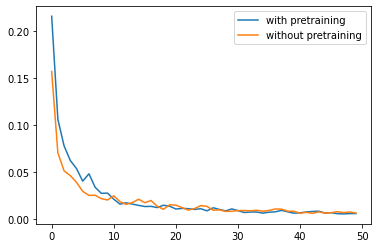

In [ ]:
plt.plot(clf.history['loss'], label='with pretraining')
plt.plot(clf2.history['loss'], label='without pretraining')
plt.legend()

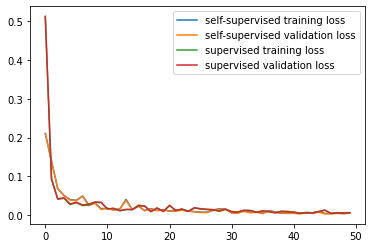

In [ ]:
plt.plot(clf.history['train_logloss'], label='self-supervised training loss')
plt.plot(clf.history['valid_logloss'], label='self-supervised validation loss')
plt.plot(clf2.history['train_logloss'], label='supervised training loss')
plt.plot(clf2.history['valid_logloss'], label='supervised validation loss')
plt.legend()

In [ ]:
preds_valid2 = clf2.predict_proba(x_valid) #valid set
preds_valid_2 = preds_valid2[:,1]
pred_valid2 =[ 0 if i < 0.5 else 1 for i in preds_valid_2]

confusion_matrix(y_valid, pred_valid2)

array([[45435,    55],
       [    0,    79]])

In [ ]:
r2 = recall_score(y_valid, pred_valid2)
print(f"Recall for 'Fraud Detection' : {r2}")
f12 = f1_score(y_valid, pred_valid2)
print(f"F1 score for 'Fraud Detection' : {f12}")

Recall for 'Fraud Detection' : 1.0
F1 score for 'Fraud Detection' : 0.7417840375586855


In [ ]:
preds2 = clf2.predict_proba(x_test)
test_pred_2 = preds2[:,1]
test_pred2 =[ 0 if i < 0.5 else 1 for i in test_pred_2]

In [ ]:
confusion_matrix(y_test, test_pred2)

array([[56768,    90],
       [   20,    84]])

In [ ]:
r2 = recall_score(y_test, test_pred2)
print(f"Recall for 'Fraud Detection' : {r2}")
f12 = f1_score(y_test, test_pred2)
print(f"F1 score for 'Fraud Detection' : {f12}")

Recall for 'Fraud Detection' : 0.8076923076923077
F1 score for 'Fraud Detection' : 0.60431654676259


In [ ]:
importance_tabNet_supervised = pd.DataFrame(clf2.feature_importances_,index=colnames_all).sort_values(0, ascending = False)
importance_tabNet_supervised.columns = ["importance_supervised"]
importance_tabNet_supervised.head()

,importance_supervised
v14,0.281291
v4,0.187912
v12,0.162034
v10,0.111645
v19,0.038223


## XGB

In [ ]:
clf3 = XGBClassifier(max_depth=7, learning_rate=0.2, n_estimators=200)
clf3.fit(x_train, y_train)

XGBClassifier(learning_rate=0.2, max_depth=7, n_estimators=200)

In [ ]:
preds_valid3 = clf3.predict_proba(x_valid) #valid set
preds_valid_3 = preds_valid3[:,1]
pred_valid3 =[ 0 if i < 0.5 else 1 for i in preds_valid_3]

confusion_matrix(y_valid, pred_valid3)

array([[45490,     0],
       [    0,    79]])

In [ ]:
r3 = recall_score(y_valid, pred_valid3)
print(f"Recall for 'Fraud Detection' : {r3}")
f13 = f1_score(y_valid, pred_valid3)
print(f"F1 score for 'Fraud Detection' : {f13}")

Recall for 'Fraud Detection' : 1.0
F1 score for 'Fraud Detection' : 1.0


In [ ]:
preds3 = clf3.predict_proba(x_test)
test_pred_3 = preds3[:,1]
test_pred3 =[ 0 if i < 0.5 else 1 for i in test_pred_3]

In [ ]:
confusion_matrix(y_test, test_pred3)

array([[56851,     7],
       [   25,    79]])

In [ ]:
r3 = recall_score(y_test, test_pred3)
print(f"Recall for 'Fraud Detection' : {r3}")
f13 = f1_score(y_test, test_pred3)
print(f"F1 score for 'Fraud Detection' : {f13}")

Recall for 'Fraud Detection' : 0.7596153846153846
F1 score for 'Fraud Detection' : 0.8315789473684211


In [ ]:
preds3 = clf3.predict_proba(x_test)
test_pred_3 = preds3[:,1]
test_pred3 =[ 0 if i < 0.5 else 1 for i in test_pred_3]

In [ ]:
importance_xgb = pd.DataFrame(clf3.feature_importances_,index=colnames_all).sort_values(0, ascending = False)
importance_xgb.columns = ["importance_xgb"]
importance_xgb.head()

,importance_xgb
v17,0.450993
v14,0.054990
v10,0.054656
v4,0.030411
v27,0.030065


---

## 알고리즘별 성능 비교

- Tabnet self-supervised vs Tabnet without pretraining vs XGB

In [ ]:
df_performance = pd.DataFrame({"self-supervised":[r, f1], "supervised":[r2, f12], "xgb":[r3, f13]}, index=['Recall', 'Precision']).reset_index(drop=True)
df_performance

,self-supervised,supervised,xgb
0,0.826923,0.807692,0.759615
1,0.609929,0.604317,0.831579


In [80]:
df_var_imp = pd.DataFrame({'self_supervised':importance_tabNet_self.index, 
                           'supervised': importance_tabNet_supervised.index, 
                           'xgb':importance_xgb.index})
df_var_imp.head()

,self_supervised,supervised,xgb
0,v16,v14,v17
1,v9,v4,v14
2,v14,v12,v10
3,v18,v10,v4
4,v1,v19,v27


## Tabnet 모델의 장단점



*   장점 
  - 중요 변수를 확인할 수 있음
  - 패키지가 제공되어있어 이용 편리
  - label 없는 경우 사용 가능
*   단점 
  - 시간 오래 걸림
  - pretrainer 설정에 큰 영향을 받음



## 참고문헌

- https://www.kaggle.com/optimo/selfsupervisedtabnet

- https://www.geeksforgeeks.org/tabnet/#:~:text=TabNet%20was%20proposed%20by%20the,%2C%20finance%2C%20marketing%2C%20etc.

- https://www.section.io/engineering-education/what-is-self-supervised-learning/